# Costa Rican Household Poverty Level Prediction

또 다른 Kaggle 도전에 오신 것을 환영합니다! 코스타리카 가계 빈곤 수준 예측 대회의 목적은 개인의 특성과 가정의 특성을 모두 활용하여 가정의 빈곤 수준을 예측할 수 있는 머신러닝 모델을 개발하는 것입니다. 이 "선행을 위한 데이터 과학" 프로젝트는 사람들이 광고를 클릭하게 하는 것보다 사회에 더 유익한 일에 우리의 기술을 투입할 수 있는 기회를 제공합니다!

이 노트에서는 전체 머신러닝 솔루션에 대해 살펴보겠습니다. 먼저 문제를 소개하고, 데이터셋에 대한 철저한 탐색 데이터 분석을 수행하고, 기능 엔지니어링을 수행하고, 여러 머신러닝 모델을 사용해 보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 출력을 검사하고, 그리십시오. 

## Problem and Data Explanation

문제 및 데이터 설명입니다.
이 대회의 데이터는 train.csv와 test.csv의 두 가지 파일로 제공됩니다. 교육 세트에는 9557개의 행과 143개의 열이 있는 반면 검정 세트에는 23856개의 행과 142개의 열이 있습니다. 각 행은 한 개인을 나타내며, 각 열은 개인 또는 개인의 가정에 대한 특징입니다. 교육 세트에는 1-4 척도로 빈곤 수준을 나타내며 경쟁사의 레이블인 목표라는 추가 열이 있습니다. 1의 값은 극빈입니다.

이것은 감독되는 다중 클래스 분류 기계 학습 문제입니다.

감독: 교육 데이터의 레이블과 함께 제공됩니다.
다중 클래스 분류: 레이블은 4개의 클래스가 있는 이산형 값입니다.
객관적으로
목적은 빈곤을 가구 단위로 예측하는 것입니다. 우리는 개개인의 고유한 특징을 가진 개인 수준에 대한 데이터를 제공받지만 그들의 가계에 대한 정보도 제공합니다. 작업에 대한 데이터 세트를 만들려면 각 가구의 개별 데이터를 일부 집계해야 합니다. 게다가, 우리는 시험 세트에 있는 모든 개인에 대해 예측을 해야 하는데, "가장만 채점에 사용된다"는 것은 우리가 가구 단위로 빈곤을 예측하기를 원한다는 것을 의미합니다.

중요 사항: 교육 데이터에서 모든 가구원의 라벨은 동일해야 하지만, 동일한 가구원의 라벨이 서로 다른 오류가 있습니다. 이 경우 각 가구의 가장에 대한 레이블을 사용하도록 지시받았으며, 이 레이블은 parentesco1 == 1.0인 행으로 식별할 수 있습니다. 이 문제를 해결하는 방법은 노트에서 다루겠습니다(자세한 내용은 경쟁업체의 주요 논의를 참조하십시오).

- 1 = extreme poverty (극심한 빈곤)
- 2 = moderate poverty (적당한 빈곤)
- 3 = vulnerable households (취약계층)
- 4 = non vulnerable households (비취약 계층)



143개 열에 대한 설명은 경기 문서에서 확인할 수 있지만, 몇 가지 유의할 사항은 다음과 같습니다.

- ID : 각 개인에 대한 고유 식별자. 이 기능은 우리가 사용하는 기능이 아닙니다.
- idhogar : 각 가구의 고유 식별자입니다. 이 변수는 특징이 아니지만 한 가구의 모든 개인이 동일한 식별자를 갖게 되므로 가구별로 개인을 그룹화하는 데 사용됩니다.
- parentesco1 : 이 사람이 가장인지 여부를 나타냅니다.
- target : 한 가구의 모든 구성원에 대해 동일해야 하는 레이블입니다.

모델을 만들 때 각 가구당 가장의 빈곤수준을 표기한 라벨을 가지고 세대별로 교육할 것입니다. 원시 데이터에는 가구와 개인의 특성이 혼재되어 있는데 개별 데이터의 경우 가구별로 이를 집계할 수 있는 방법을 찾아야 할 것 같습니다. 개인들 중 일부는 가장이 없는 가정에 속해 있는데, 유감스럽게도 우리는 이 데이터를 훈련에 사용할 수 없습니다. 데이터와 관련된 이러한 문제는 실제 데이터에서 완전히 일반적인 문제이므로 데이터 과학 작업에서 발생할 데이터 세트를 준비하기에 적합합니다.

### Read in Data and Look at Summary Information


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [3]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


즉, 정수 열이 130개, 부동(숫자) 열이 8개, 객체 열이 5개 있습니다. 정수 열은 불변 변수(0 또는 1을 차지하는) 또는 이산형 순서 값을 갖는 순서형 변수를 나타냅니다. 객체 열은 기계 학습 모델에 직접 입력될 수 없기 때문에 문제가 될 수 있습니다.

열차보다 행(개체)이 더 많은 검정 데이터를 살펴보겠습니다. 대상이 없기 때문에 열이 하나 적습니다!

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


### Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.



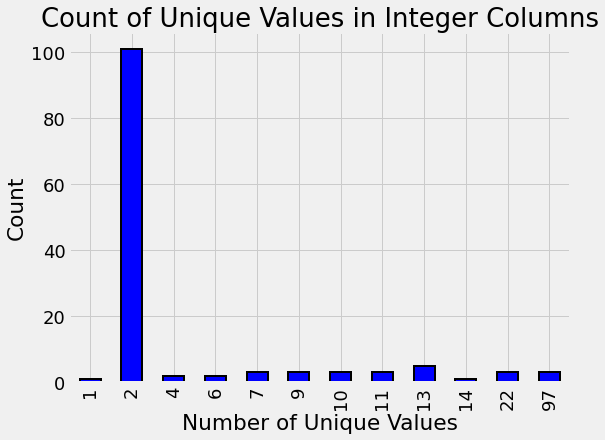

In [6]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

고유한 값이 2개만 있는 열은 부울란(0 또는 1)을 나타냅니다. 많은 경우, 이 불린 정보는 이미 가구 수준에 있습니다. 예를 들어, 냉장 칸에는 냉장고의 보유 여부가 표시됩니다. 가구 레벨에 있는 부울 컬럼에서 피쳐를 만들 시간이 되면 이를 집계할 필요가 없습니다. 그러나 개별 수준에 있는 부울 열을 집계해야 합니다.

### Float Columns

또 다른 열 유형은 연속형 변수를 나타내는 부동 소수입니다. 우리는 모든 부동 열의 분포를 보여주기 위해 빠른 분포도를 만들 수 있습니다. OrderedDict를 사용하여 부족 수준을 색상에 매핑합니다. 이렇게 하면 키와 값이 (일반 Python 사전과 달리) 지정한 순서에 따라 유지되기 때문입니다.

다음 그래프는 목표값으로 색상이 지정된 부동 열의 분포를 보여 줍니다. 이 그래프를 통해 가구의 빈곤 수준에 따라 변동 분포에 유의한 차이가 있는지 확인할 수 있습니다.

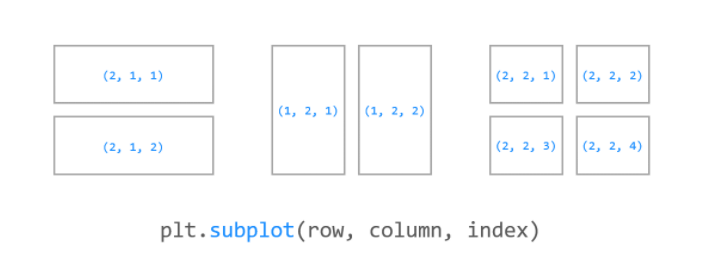

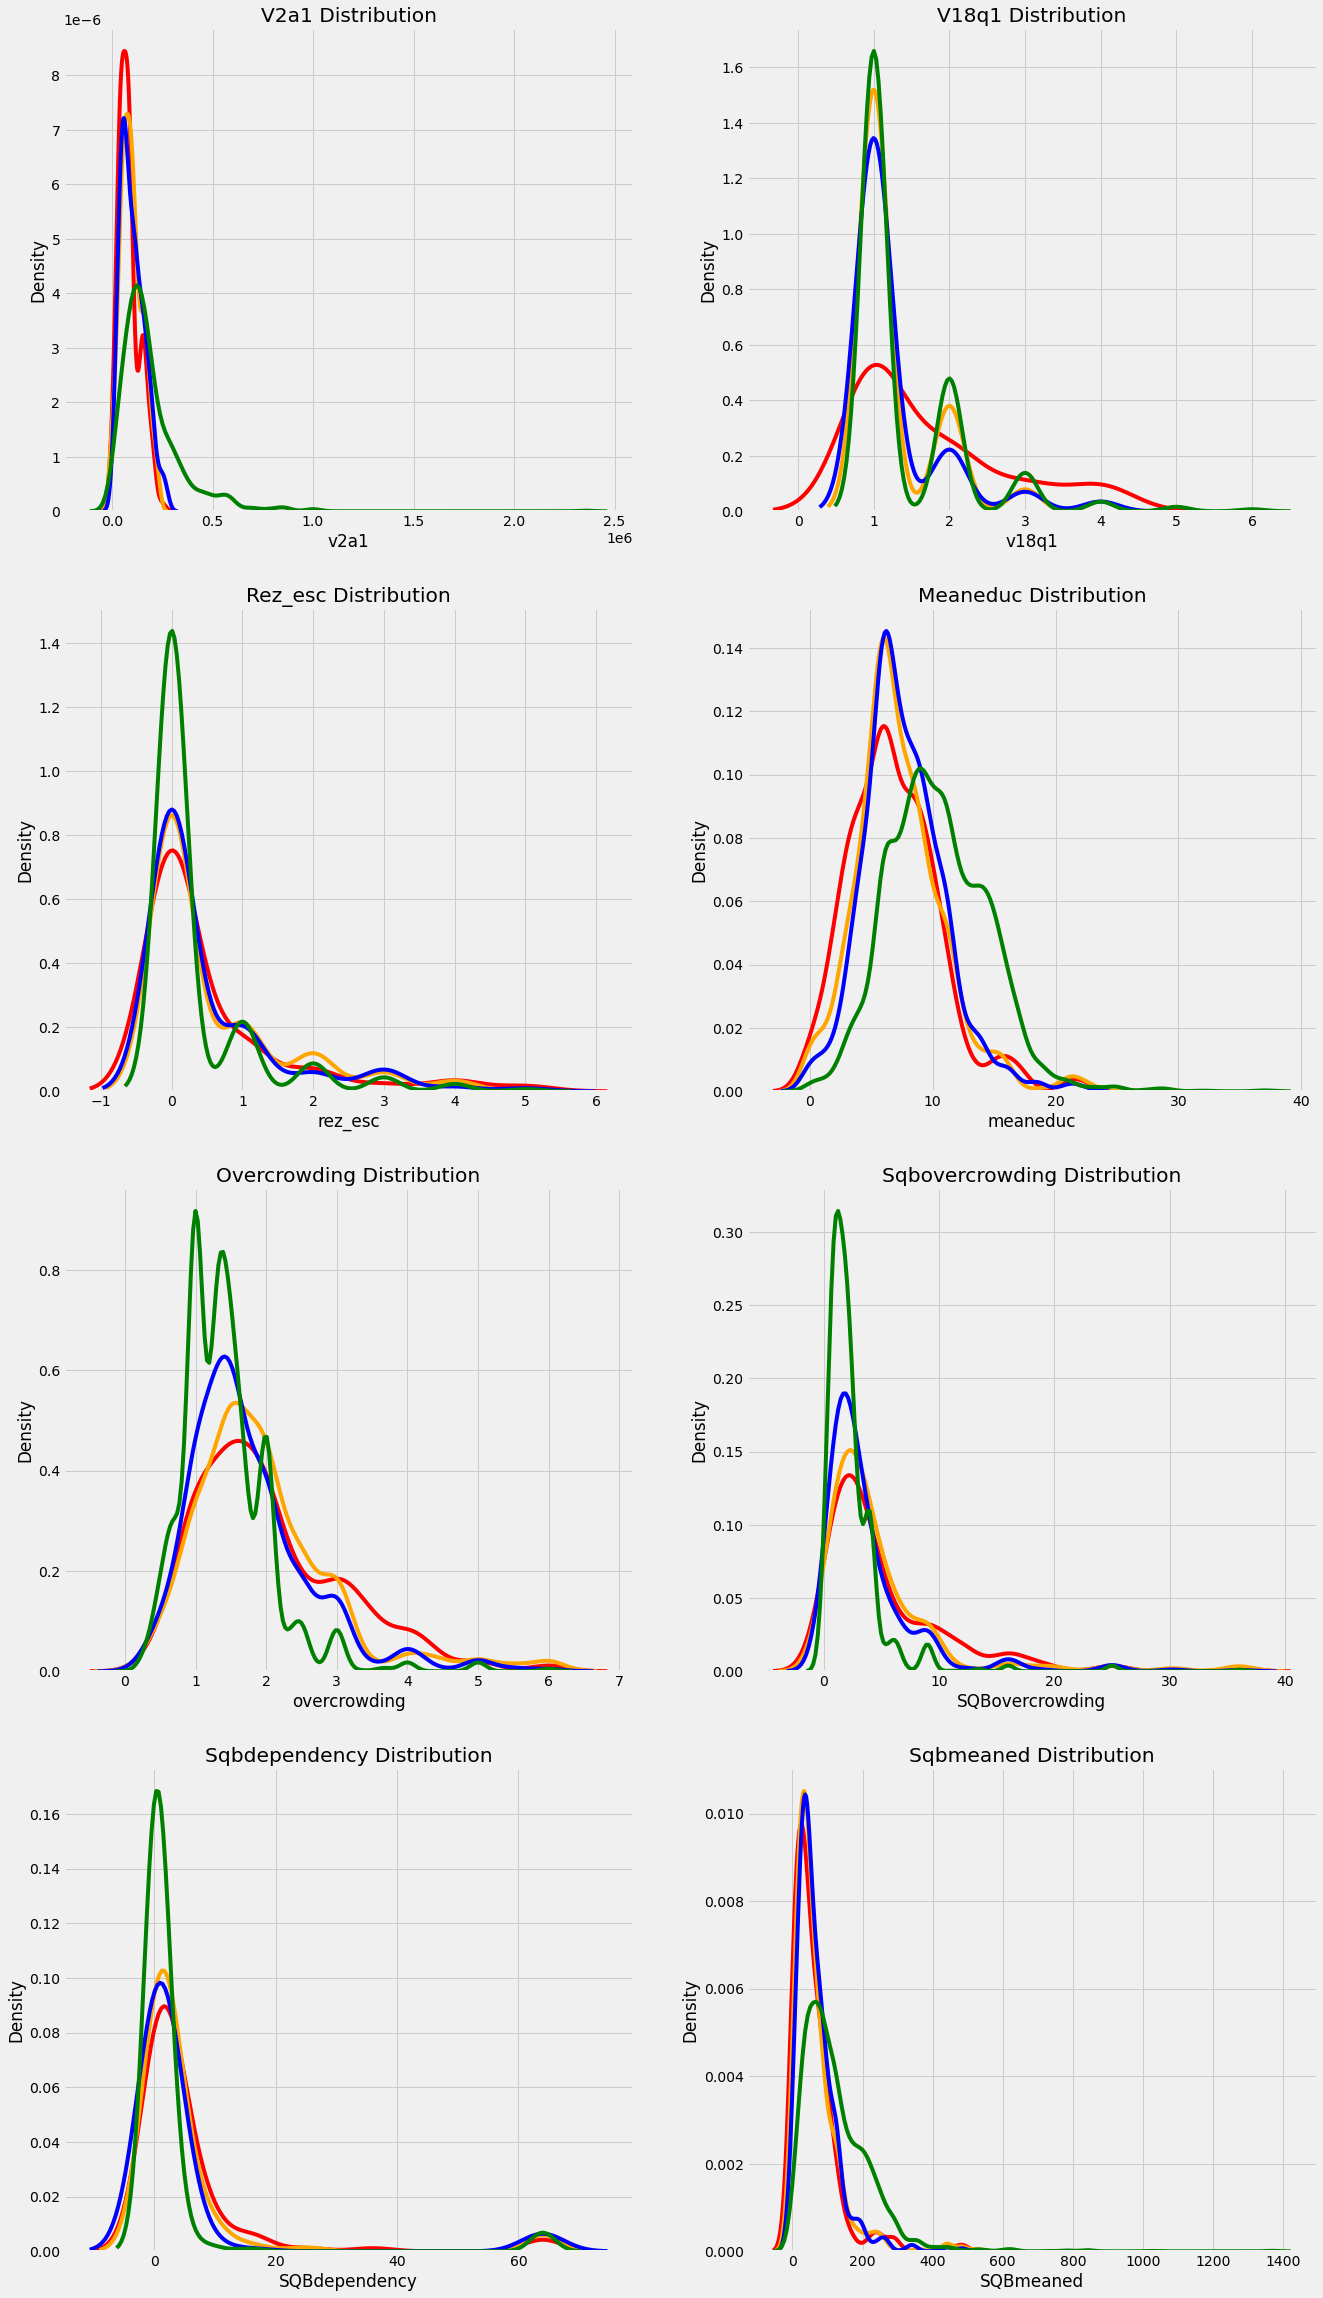

In [7]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight') # 스타일시트

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# x축
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # x축 일부(색상)
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [8]:
train.select_dtypes('float')

,v2a1,v18q1,rez_esc,meaneduc,overcrowding,SQBovercrowding,SQBdependency,SQBmeaned
0,190000.0,NaN,NaN,10.00,1.000000,1.000000,0.0000,100.0000
1,135000.0,1.0,NaN,12.00,1.000000,1.000000,64.0000,144.0000
2,NaN,NaN,NaN,11.00,0.500000,0.250000,64.0000,121.0000
3,180000.0,1.0,1.0,11.00,1.333333,1.777778,1.0000,121.0000
4,180000.0,1.0,NaN,11.00,1.333333,1.777778,1.0000,121.0000
...,...,...,...,...,...,...,...,...
9552,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9553,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9554,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9555,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625


나중에 변수와 목표값 사이의 상관 관계를 계산하여 형상 간의 관계를 측정하겠지만, 이러한 그림을 통해 모형과 가장 "관련성 있는" 변수가 무엇인지 알 수 있습니다. 예를 들어, 가구 내 성인의 평균 교육을 나타내는 평균 교육은 빈곤 수준과 관련이 있는 것으로 보입니다: 높은 평균 성인 교육은 목표의 높은 가치로 이어지고 덜 심각한 빈곤 수준으로 이어집니다. 교육의 중요성에 대한 주제는 우리가 이 공책에서 계속해서 다시 보게 될 주제입니다!

### Object Columns


In [9]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


마지막 열 type은 아래와 같이 볼 수 있는 'object'입니다.

Id 및 idhogar 개체 유형은 식별 변수이므로 의미가 있습니다. 
그러나 나머지 열은 기계 학습을 수행하기 전에 해결해야 할 문자열과 숫자가 혼합된 것으로 보입니다. 

- dependency : 종속율, =(19세 미만 가구원 수)/(19~64세 가구원 수)

- edjefe : 남성 가장의 교육 연수는 에스콜라리(교육 연수), 세대주 및 성별 상호 작용을 기반으로 합니다(예=1 및 아니오=0).

- edjefa : 여성 가장의 교육 연수는 에스콜라리(교육 연수), 세대주 및 성별 상호 작용을 기반으로 합니다(예=1 및 아니오=0).

이러한 설명으로 문제가 해결되었습니다. 이 세 변수의 경우 "예" = 1 및 "아니오" = 0입니다. 매핑을 사용하여 변수를 수정하고 부동 변수로 변환할 수 있습니다.

In [10]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


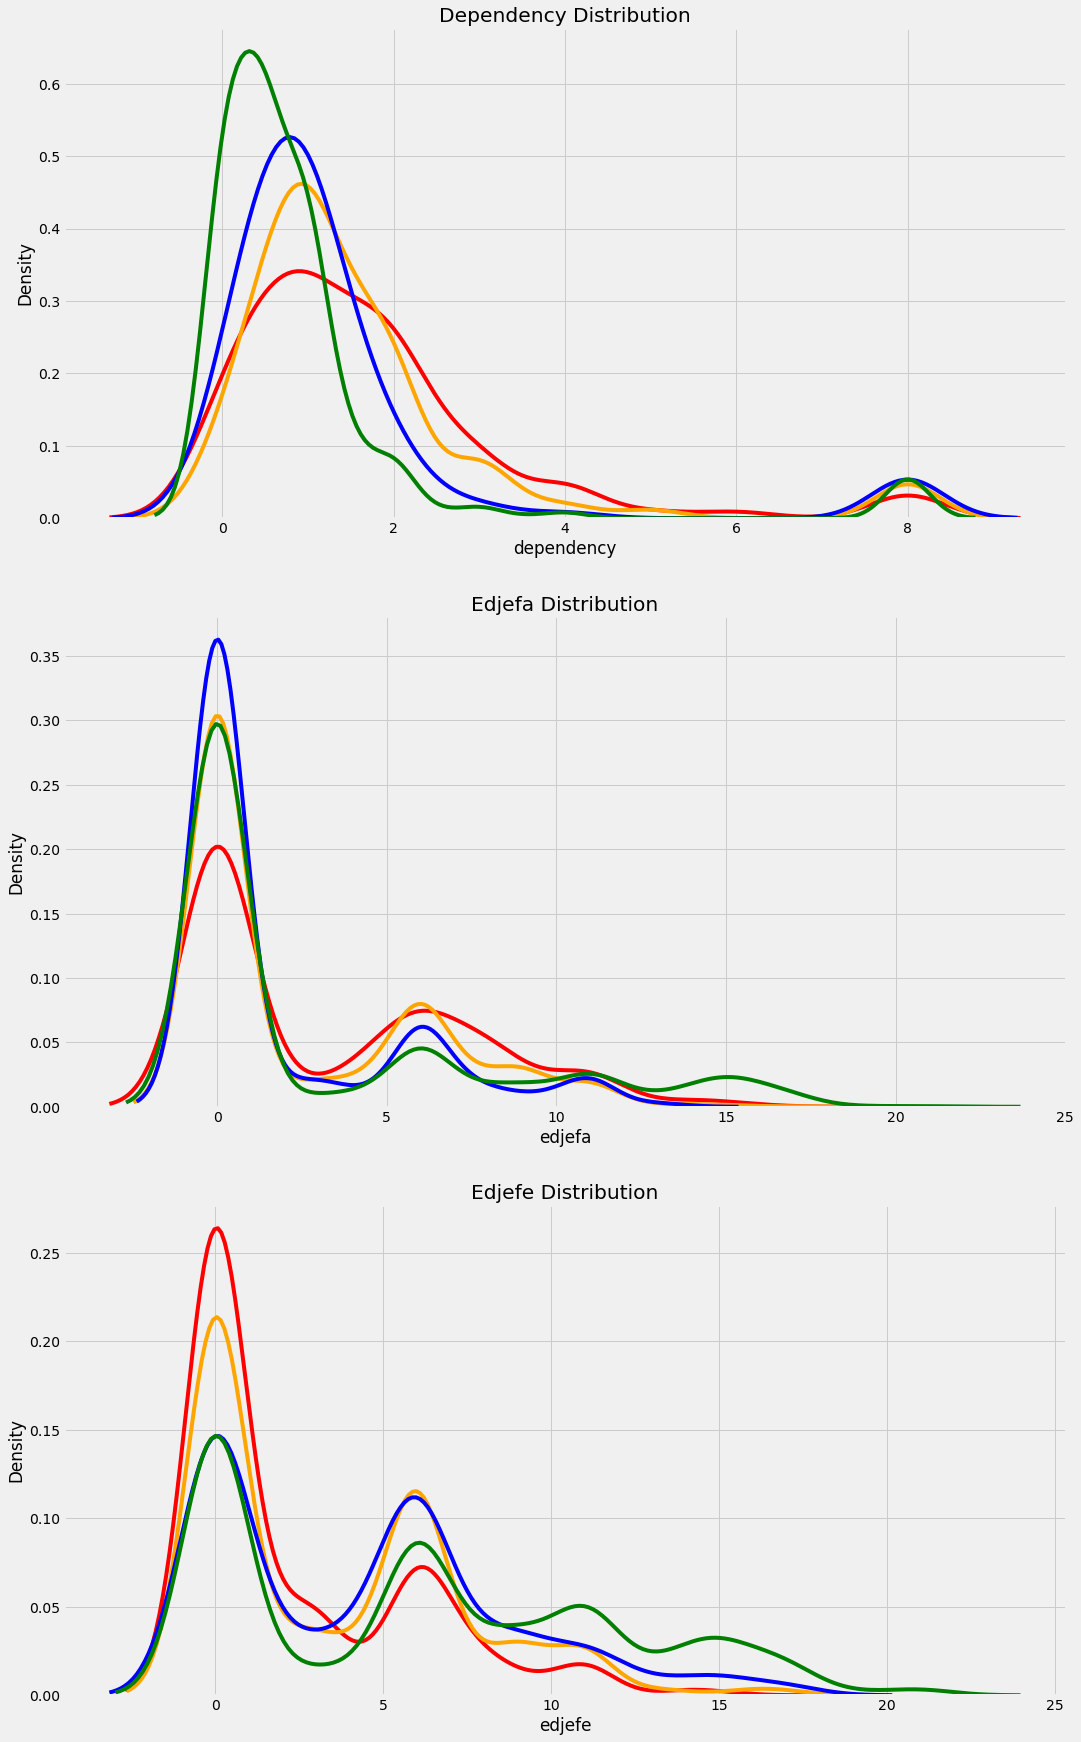

In [11]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [12]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Exploring Label Distribution

다음으로 레이블 분포를 보면 얼마나 불균형적인 문제인지 알 수 있습니다. 4가지 가능한 정수 수준이 있는데, 이것은 빈곤의 4가지 수준을 나타냅니다.
올바른 레이블을 보려면 parentesco1 == 1인 열에만 부분 집합을 취합니다. 이 열은 '가장'인 레이블이기 때문입니다. (식구 4명 빈곤 -> 가장 1명 빈곤)

아래 막대 그림은 (검정 레이블이 없으므로) 교육용 레이블의 분포를 보여줍니다.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

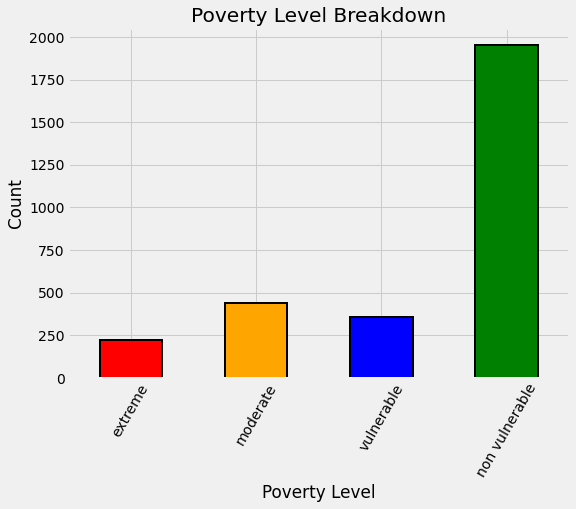

In [13]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']] # df.loc[row, columns]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

In [14]:
data['parentesco1'] == 1

0         True
1         True
2         True
3        False
4        False
         ...  
33408    False
33409     True
33410    False
33411    False
33412    False
Name: parentesco1, Length: 33413, dtype: bool

In [15]:
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]
train_labels

,Target,idhogar
0,4.0,21eb7fcc1
1,4.0,0e5d7a658
2,4.0,2c7317ea8
5,4.0,2b58d945f
8,4.0,d6dae86b7
...,...,...
9535,1.0,9bbf7c6ca
9541,2.0,e87e70c06
9545,4.0,a8eeafc29
9551,2.0,212db6f6c


In [16]:
label_counts = train_labels['Target'].value_counts().sort_index()
label_counts

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

우리는 불균형 클래스 문제를 다루고 있습니다(대회 주최자가 가중치 F1 대신 매크로 F1 점수를 메트릭으로 선택하는 이유는 매우 흥미롭습니다). 취약계층으로 분류하는 가구가 다른 어떤 범주보다 훨씬 많습니다. 극빈층이 가장 작습니다.

불균형 분류 문제의 한 가지 문제는 머신러닝 모델이 훨씬 적은 예를 보기 때문에 소수 수업을 예측하는 데 어려움을 겪을 수 있다는 것입니다. 이것을 인간의 관점에서 생각해보세요: 만약 우리가 빈곤을 분류하고 있고, 극심한 빈곤보다 빈곤이 없는 경우를 훨씬 더 많이 본다면, 우리는 더 적은 노출 때문에 높은 빈곤 가구를 식별하는 것을 더 어렵게 만들 것입니다. 클래스 불균형을 해결할 수 있는 한 가지 잠재적인 방법은 오버샘플링을 사용하는 것입니다(고급 노트북에서 다루어짐).

## Addressing Wrong Labels

다른 현실적인 데이터 세트와 마찬가지로 코스타리카 빈곤 데이터에도 몇 가지 문제가 있습니다. 일반적으로 데이터 과학 프로젝트의 80%는 데이터를 정리하고 이상 징후/오류를 수정하는 데 사용됩니다. 이는 사람 입력 오류, 측정 오류 또는 정확하지만 눈에 띄는 극단값일 수 있습니다. 이 문제에 대해, 같은 가정의 개인들은 다른 빈곤 수준을 가지고 있기 때문에 일부 라벨은 정확하지 않습니다. 왜 그럴지도 모르지만 가장을 진짜 꼬리표로 쓰라고 했습니다.

그 정보가 우리의 일을 훨씬 쉽게 만들어 주지만, 실제 문제에서 우리는 왜 라벨이 잘못되었는지, 그리고 그 문제를 스스로 해결할 수 있는 방법을 알아내야 할 것입니다. 이 섹션에서는 레이블의 문제를 수정할 필요는 없지만, 이 문제를 어떻게 처리할 수 있는지 보여주기 위해 노트에 보관했습니다.


### Identify Errors

먼저 오류를 찾아 수정해야 합니다. 가족 구성원의 레이블이 다른 가구를 찾기 위해 가구별로 데이터를 그룹화한 다음 대상의 고유 값이 하나만 있는지 확인할 수 있습니다.


In [17]:
# True면 가족 모두 빈곤수준={1,2,3,4} 중 하나로 통일함, False면 빈곤수준={1,2,3,4} 중 2개 이상이 존재
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
all_equal

idhogar
001ff74ca    True
003123ec2    True
004616164    True
004983866    True
005905417    True
             ... 
ff9343a35    True
ff9d5ab17    True
ffae4a097    True
ffe90d46f    True
fff7d6be1    True
Name: Target, Length: 2988, dtype: bool

In [18]:
# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


한 가지 예를 살펴보겠습니다.


In [19]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최 측은 올바른 라벨이 가장의 라벨이며, 여기서 parentesco1 == 1이라고 말합니다. 이 가구의 경우, 올바른 라벨은 모든 구성원을 위한 3입니다. 우리는 이 가정의 모든 사람들을 올바른 빈곤 수준으로 재할당함으로써 (나중에 보여지는 것처럼) 이것을 바로잡을 수 있습니다. 실제 상황에서는 혼자서(또는 팀의 도움을 받아) 문제를 해결하는 어려운 결정을 내려야 할 수도 있습니다.


### Families without Heads of Household

우리는 같은 가구에 있는 개인에게 가장의 라벨을 지정함으로써 라벨 불일치를 수정할 수 있습니다. 하지만, 여러분은 이렇게 물을지도 모릅니다: "만약 가장이 없는 가정이 있다면요? 그리고 만약 그 가구 구성원들의 라벨에 대한 가치관이 다르면 어떻게 될까요?"

그럼, 당신이 물었으니, 그 질문을 정확히 조사해보죠!



In [21]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()
households_leader

idhogar
001ff74ca    1
003123ec2    1
004616164    1
004983866    1
005905417    1
            ..
ff9343a35    1
ff9d5ab17    1
ffae4a097    1
ffe90d46f    1
fff7d6be1    1
Name: parentesco1, Length: 2988, dtype: int64

In [22]:
# 가장이 없는 그룹리스트
households_leader[households_leader == 0].index

Index(['03c6bdf85', '09b195e7a', '1367ab31d', '1bc617b23', '374ca5a19',
       '61c10e099', '6b1b2405f', '896fe6d3e', 'a0812ef17', 'ad687ad89',
       'b1f4d89d7', 'bfd5067c2', 'c0c8a5013', 'd363d9183', 'f2bfa75c4'],
      dtype='object', name='idhogar')

In [23]:
# 가장이 없는 그룹데이터프레임
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :] 
households_no_head

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
4935,ID_717302050,NaN,0,8,0,1,1,0,NaN,0,2,2,0,2,2,0,4,4,4,4,6,NaN,4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,09b195e7a,2,2,0,4,1.000000,6.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,5,0.800000,1,0,0,0,0,0,1,1,4,1,0,0,0,0,0,0,1,34,36,1156,16,36,4,0.640000,1.000000,36.000000,1156,3
4975,ID_ff6f13458,NaN,0,4,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,9,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,896fe6d3e,2,2,0,4,1.000000,9.0,0.0,7.500000,0,0,0,0,0,1,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,16,81,256,16,81,4,4.000000,1.000000,56.250000,256,3
5391,ID_64c9eabac,NaN,0,5,0,1,1,0,NaN,0,1,1,0,2,2,0,3,3,3,3,14,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,61c10e099,0,3,0,3,0.000000,6.0,0.0,8.666667,0,0,0,0,0,0,0,1,0,3,1.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,20,196,400,9,36,0,1.000000,0.000000,75.111115,400,3
5396,ID_8948b1f91,90000.0,0,5,0,1,1,0,NaN,2,1,3,1,1,2,3,2,5,5,5,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,374ca5a19,3,2,0,5,1.500000,6.0,0.0,8.500000,0,1,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,10,9,100,25,36,9,2.777778,2.250000,72.250000,100,3
6443,ID_8ddb34d2c,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3.0,0.0,6.000000,1,0,0,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,7,0,49,16,9,4,4.000000,1.000000,36.000000,49,3
6444,ID_03e2f23b0,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,6,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,13,36,169,16,9,4,4.000000,1.000000,36.000000,169,3
7086,ID_ba2ac56bb,NaN,0,4,0,1,1,0,NaN,0,1,1,2,2,4,2,3,5,5,5,11,NaN,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1367ab31d,3,2,0,5,1.500000,16.0,0.0,18.000000,0,0,0,0,1,0,0,0,0,2,2.500000,1,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,1,19,121,361,25,256,9,6.250000,2.250000,324.000000,361,3
7438,ID_7ba374a80,NaN

In [24]:
# 가장이 없는 가구 수
print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [25]:
# 가장이 없는 가구 & 빈곤수준을 다르게 한 가구
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


다행이네요! 이것은 머리도 없고 멤버들의 라벨 가치도 다른 가정을 걱정할 필요가 없다는 것을 의미해요! 주최자들에 따르면, 만약 한 가정에 가장이 없다면, 진정한 라벨은 없는 것이라고 합니다. 그러므로, 우리는 사실 가장이 없는 어떤 가정도 훈련에 사용하지 않을 것입니다. 그럼에도 불구하고, 이 데이터 조사 과정을 거치는 것은 여전히 좋은 연습입니다!


### Correct Errors

이제 우리는 가장이 있는 가구와 구성원의 빈곤 수준이 다른 가구들에 대한 라벨을 수정할 수 있습니다.



In [26]:
# 빈곤 수준을 다르게 적은 가구
not_equal.index

Index(['0172ab1d9', '03f4e5f4d', '0511912b6', '078a0b6e2', '09e25d616',
       '0f3e65c83', '0f9494d3a', '15a891635', '17fb04a62', '18832b840',
       '26b3a0f41', '288579c97', '28893b5e7', '2c9872b82', '2cb443214',
       '309fb7246', '30a70901d', '3c6973219', '3c73c107f', '3df651058',
       '3fe29a56b', '410194c8b', '417865404', '42ec8bef5', '43b9c83e5',
       '44f219a16', '46af47063', '4b6077882', '4c2dba109', '4dc11e11f',
       '4e19bd549', '50e064ee8', '513adb616', '54118d5d9', '55a662731',
       '564eab113', '594d3eb27', '5c3f7725d', '5c6f32bbc', '5e9329fc6',
       '614b48fb7', '636330516', '654ef7612', '67ad49822', '6833ac5dc',
       '694a0cbf4', '6a389f3de', '6bcf799cf', '6c543442a', '71cd52a80',
       '73d85d05d', '7ad269eef', '7c57f8237', '7e9d58c5c', '7ea6aca15',
       '80a66379b', '811a35744', '8242a51ec', '8420bcfca', '8ae3e74ca',
       '8bb6da3c1', '932287f5d', '9bbf7c6ca', 'a20ff33ba', 'a3288e6fa',
       'a94a45642', 'bcaa2e2f5', 'bcab69521', 'bd82509d1', 'be91

In [27]:
# Iterate through each household
for household in not_equal.index:
    # 빈곤수준을 다르게 적은 가구의 가장의 빈곤수준
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # 빈곤수준을 통일
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


라벨에는 가장만 사용할 예정이기 때문에 이 단계가 꼭 필요한 것은 아니지만 실제 발생할 수 있는 데이터 오류를 수정하기 위한 워크플로를 보여줍니다. 야근이라고 생각하지 말고 경력을 위해 연습하세요!


## Missing Variables

먼저 각 열의 결측값 백분율을 살펴볼 수 있습니다.


In [28]:
data.isnull().sum()

Id                     0
v2a1               24263
hacdor                 0
rooms                  0
hacapo                 0
                   ...  
SQBovercrowding        0
SQBdependency          0
SQBmeaned             36
agesq                  0
Target             23856
Length: 143, dtype: int64

In [29]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data) # 33413:nrow

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000



테스트 데이터를 위해 NaN을 만들었기 때문에 Target에 대해서는 걱정하지 않아도 됩니다. 그러나 결측값 비율이 높은 나머지 3개 열을 처리해야 합니다.

#### rez_esc : rez_esc는 7세에서 19세 사이의 인구 중 입학에 늦는 연수를 의미한다. (8살에 입학해야했는데 11살에 입학했다면 rez_esc=3)
#### v2a1 : 월세



### v18q1: 태블릿 수입니다.
    
가족이 소유한 태블릿의 수를 나타내는 v18q1부터 시작하겠습니다.</br>
우리는 이 변수의 값 개수를 볼 수 있습니다.</br>
이것은 가계 변수이기 때문에 가구 단위로만 보는 것이 타당하기 때문에 가장의 행만 선정하도록 하겠습니다.


### Function to Plot Value Counts

서로 다른 열에 대한 값 수를 플롯할 수 있으므로 이러한 작업을 수행할 수 있는 간단한 함수를 작성할 수 있습니다!


In [30]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

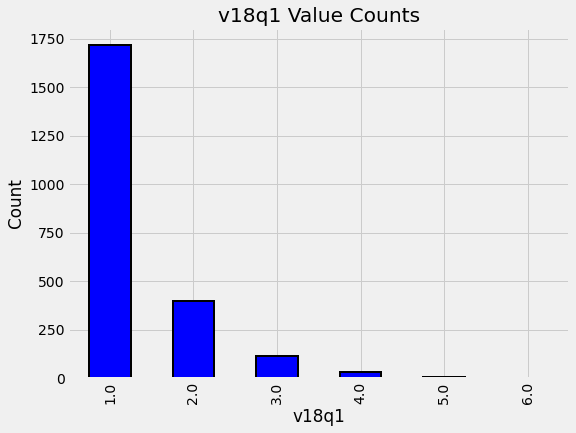

In [31]:
plot_value_counts(heads, 'v18q1')

존재하는 데이터만 기준으로 계산하면 태블릿을 가장 많이 보유하는 것이 1대인 것 같습니다. 하지만 우리는 누락된 데이터도 생각해야 합니다. 이 경우, 이 범주에 속하는 nan를 가진 가정들은 태블릿을 가지고 있지 않을 수도 있습니다! 데이터 정의를 살펴보면 v18q가 태블릿을 소유하고 있는지 여부를 나타냅니다. 우리는 우리의 가설이 들어맞는지 확인하기 위해 이 열을 태블릿의 수와 결합해서 조사해야 합니다.

v18q 값(태블릿 소유의 경우 1이고 소유하지 않는 경우 0)을 기준으로 그룹화한 다음 v18q1의 null 값 수를 계산할 수 있습니다. 이것은 null 값이 가족이 태블릿을 소유하지 않음을 나타내는지 알려줍니다.

In [32]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

그럼 문제가 해결됐네요! v18q1용 nan을 보유한 모든 제품군은 태블릿을 소유하지 않습니다. 따라서 우리는 이 결측값을 0으로 채울 수 있습니다.


In [33]:
data['v18q1'] = data['v18q1'].fillna(0)

### v2a1: 월세

다음 누락 열은 v2a1로 월세 지불을 나타냅니다.

월세 결제의 결측값뿐만 아니라 주택 소유/임대 현황을 보여주는 열인 tipovivi_ 분포도 살펴볼 수 있어 흥미로울 것입니다. 이 플롯에서는 월세 지불을 위한 nan로 주택의 소유권 상태를 보여줍니다.

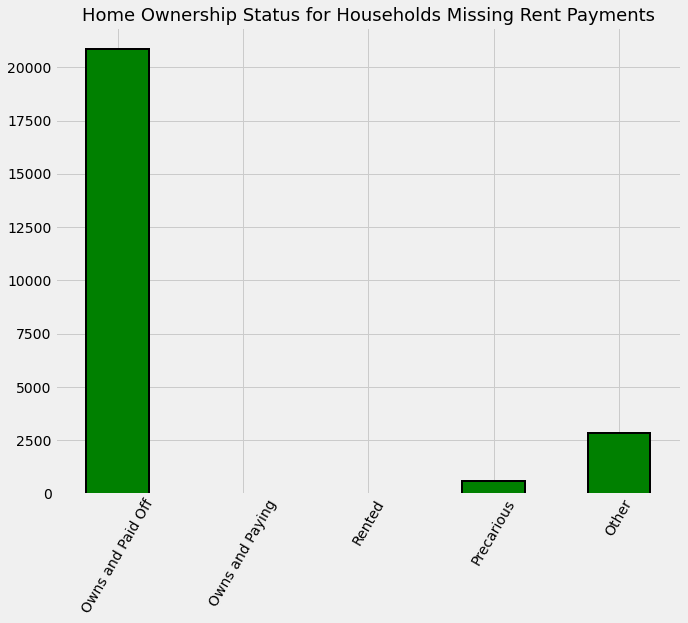

In [34]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

tipovivi1 =1 소유 및 완전 지불 주택입니다.</br>
tipovivi2, "=1 소유, 분할 지불"입니다.</br>
tipovivi3, =1 임대되었습니다.</br>
tipovivi4, =1 불안정합니다.</br>
tipovivi5, "=1 기타(기타, 대여)"입니다.

보유 주택 중 월세 납부가 누락된 주택에 대해서는 월세 납입가액을 0으로 설정할 수 있습니다. 다른 주택의 경우 결측값은 귀속시킬 수 있지만 이 가구에는 결측값이 있었다는 것을 나타내는 깃발(부울) 열을 추가할 것입니다.


In [35]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

### rez_esc: rez_esc는 7세에서 19세 사이의 인구 중 입학에 늦는 연수를 의미한다. (8살에 입학해야했는데 11살에 입학했다면 rez_esc=3)

null이면 자녀가 없다.
결측값 비율이 높은 마지막 열은 rez_esc로 학년 뒤처짐을 나타냅니다. 값이 무효인 가정의 경우 현재 학교에 자녀가 없을 가능성이 있습니다. 이 열에 결측값이 있는 사람의 연령과 결측값이 없는 사람의 연령을 찾아 이를 테스트해 보겠습니다.



In [36]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이것이 말해주는 것은 결측값을 가진 가장 나이가 많은 나이는 17세라는 것입니다. 
이것보다 나이가 더 많은 사람이라면, 우리는 그들이 단순히 학교에 있지 않다고 추측할 수 있을 것입니다. 
결손치가 있는 사람들의 나이를 살펴봐요.


In [37]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

In [38]:
data['rez_esc'].value_counts()

0.0     4474
1.0      728
2.0      336
3.0      174
4.0       80
5.0       39
99.0       1
Name: rez_esc, dtype: int64

이 대회에 대한 몇 가지 논의를 살펴보면 이 변수가 7-19세 사이의 개인에게만 정의되어 있음을 알 수 있습니다. 이 범위보다 어리거나 오래된 사람은 년 수가 없으므로 값을 0으로 설정해야 합니다. 이 변수의 경우, 개인이 19세 이상이고 결측치가 있는 경우 또는 7세 미만이고 결측치가 있는 경우 0으로 설정할 수 있습니다. 다른 사용자의 경우 귀속 값을 그대로 두고 부울 플래그를 추가합니다.


In [39]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc 열에는 특이치도 하나 있습니다. 다시 경쟁 토론 내용을 살펴보면 이 변수의 최대값이 5라는 것을 알 수 있습니다. 따라서 5를 초과하는 값은 5로 설정해야 합니다.


In [40]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables

두 범주형 변수가 서로 교호작용하는 방식을 보여 주기 위해 산점도, 면 막대 그림, 상자 그림 등 여러 가지 표시 옵션이 있습니다.

저는 이러한 선택 중 어느 것도 만족하지 못했기 때문에 아래에 함수를 작성했는데, 이 함수는 기본적으로 점의 크기가 각 x-값으로 표현되는 주어진 y-값의 백분율을 나타내는 두 개의 범주형 산점도입니다.



In [54]:
raw_counts = pd.DataFrame(data.groupby('Target')['rez_esc'].value_counts(normalize = False))
raw_counts = raw_counts.rename(columns = {'rez_esc' : 'raw_count'})
raw_counts

raw_count
Target rez_esc           
1.0    0.0            682
       1.0             27
       2.0             12
       4.0              6
       3.0              4
       5.0              3
2.0    0.0           1405
       1.0             64
       2.0             36
       3.0             18
       4.0             10
       5.0              1
3.0    0.0           1093
       1.0             41
       3.0             14
       2.0             12
       4.0              3
       5.0              2
4.0    0.0           5609
       1.0             95
       2.0             38
       3.0             19
       4.0             10
       5.0              3

In [42]:
counts = pd.DataFrame(data.groupby('Target')['rez_esc'].value_counts(normalize = True))

# Rename the column and reset the index
counts = counts.rename(columns = {'rez_esc': 'normalized_count'}).reset_index()
counts['percent'] = 100 * counts['normalized_count']
counts

,Target,rez_esc,normalized_count,percent
0,1.0,0.0,0.929155,92.915531
1,1.0,1.0,0.036785,3.678474
2,1.0,2.0,0.016349,1.634877
3,1.0,4.0,0.008174,0.817439
4,1.0,3.0,0.005450,0.544959
5,1.0,5.0,0.004087,0.408719
6,2.0,0.0,0.915906,91.590613
7,2.0,1.0,0.041721,4.172099
8,2.0,2.0,0.023468,2.346806
9,2.0,3.0,0.011734,1.173403


In [43]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

C:\Users\HOME\AppData\Local\Temp/ipykernel_11036/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


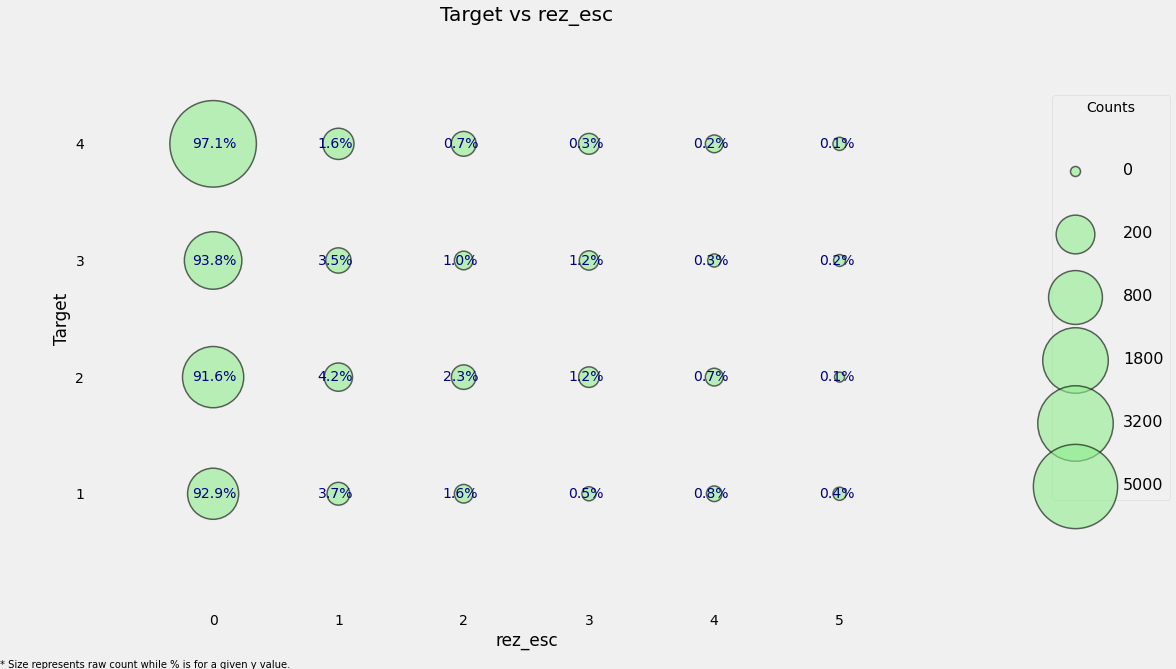

In [44]:
plot_categoricals('rez_esc', 'Target', data);

마커의 크기는 원시 카운트를 나타냅니다. 그림을 읽으려면 주어진 y 값을 선택한 다음 행을 가로질러 읽습니다. 예를 들어, 빈곤 수준이 1인 경우, 총 800여 명으로 93%의 개인이 연차가 없으며, 약 0.4%의 개인이 5년 뒤처져 약 50명이 이 범주에 속합니다. 이 줄거리는 전체 카운트와 범주 내 비율을 모두 표시하려고 합니다. 완벽하지는 않지만 시도해 보았습니다!


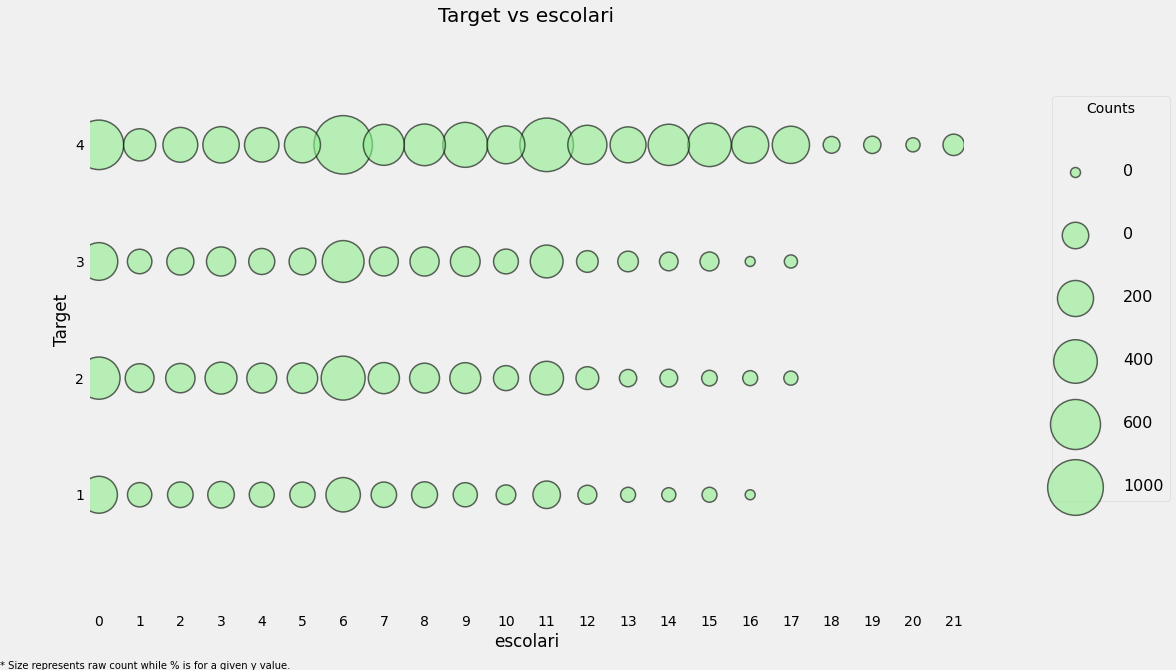

In [45]:
plot_categoricals('escolari', 'Target', data, annotate = False)

각 열의 나머지 결측값은 귀책으로 알려진 공정으로 채워집니다. 일반적으로 사용되는 몇 가지 귀책 유형이 있으며 가장 간단하고 효과적인 방법 중 하나는 결측값을 열의 중위수로 채우는 것입니다.


결측값의 마지막 단계로, 두 값 중 하나가 결측된 경우의 목표값 분포를 표시할 수 있습니다.


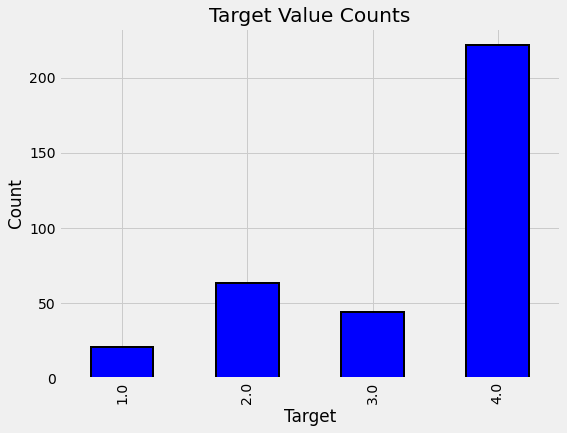

In [47]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

이 분포는 일반적으로 모든 데이터에 대해 일치하는 것으로 보입니다.


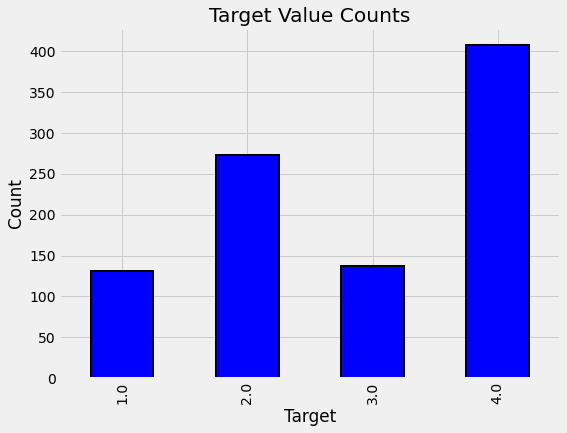

In [48]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

이것은 2의 높은 유병률을 고려할 때 더 많은 빈곤의 지표가 될 수 있는 것처럼 보입니다: 중간 정도의 빈곤.

이것은 중요한 점을 나타냅니다. 때로는 누락된 정보도 제공된 정보만큼 중요합니다.


In [ ]:
# Feature Engineering


In [55]:
id_ = ['Id', 'idhogar', 'Target']

In [56]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [57]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [58]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [59]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


In [61]:
Counter(x).values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [62]:
type(Counter(x).values())

dict_values

### Squared Variables


먼저, 가장 쉬운 단계는 모든 제곱 변수를 제거하는 것입니다. 선형 모델이 비선형 관계를 학습하는 데 도움이 될 수 있기 때문에 피쳐 엔지니어링의 일부로 변수가 제곱되거나 변환되는 경우가 있습니다. 그러나 더 복잡한 모델을 사용할 것이기 때문에 이러한 사각 기능은 중복됩니다. 그것들은 정사각형 버전이 아닌 버전과 높은 상관관계가 있으므로 관련 정보를 추가하고 교육을 느리게 하여 실제로 우리 모델을 해칠 수 있습니다.

For an example, let's take a look at SQBage vs age.



C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


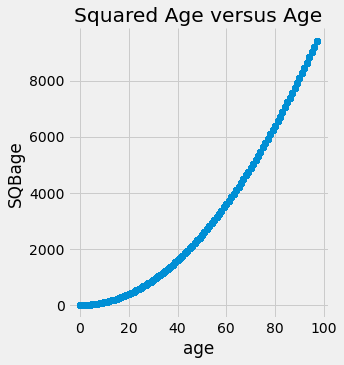

In [63]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

이 변수들은 높은 상관관계가 있으므로 두 변수 모두를 데이터에 보관할 필요가 없습니다.


In [64]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

### Id Variables

식별을 위해 필요하므로 데이터에 있는 그대로 유지됩니다.

### Household Level Variables

먼저 가장으로 부분 집합한 다음 가구 수준 변수로 부분 집합을 취하겠습니다.



In [75]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

대부분의 가구 수준 변수의 경우 이러한 변수를 그대로 유지할 수 있습니다. 각 가구에 대한 예측을 수행하고자 하므로 이러한 변수를 특징으로 사용합니다. 그러나 일부 중복 변수를 제거하고 기존 데이터에서 파생된 기능을 추가할 수도 있습니다.


### Redundant Household Variables
가구 변수들 간의 상관관계를 살펴봅시다. 상관 관계가 너무 높은 변수가 있으면 상관 관계가 높은 변수 쌍 중 하나를 제거할 수 있습니다.

다음 코드는 절대 크기 상관 관계가 0.95보다 큰 변수를 식별합니다.


In [71]:
np.triu(np.ones(corr_matrix.shape), k=1)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)

C:\Users\HOME\AppData\Local\Temp/ipykernel_11036/3676972537.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)


array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [70]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

C:\Users\HOME\AppData\Local\Temp/ipykernel_11036/2621372733.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,v18q1,tamhog,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,qmobilephone
Target,NaN,-0.136275,-0.096313,0.068230,0.119607,0.254469,-0.078851,-0.104545,-0.209131,-0.096893,-0.152979,-0.040128,-0.039861,0.005231,0.275452,0.016832,-0.054463,-0.114144,-0.103487,0.014357,0.032872,-0.026240,0.031516,0.295249,0.062961,-0.046518,-0.055818,0.021908,-0.009437,-0.051036,-0.007696,-0.049932,0.097592,-0.062316,-0.083835,-0.017669,-0.054739,0.158804,-0.083063,-0.162796,0.156930,-0.060286,-0.142433,-0.041221,NaN,0.023812,-0.208170,-0.162652,0.280947,-0.209181,-0.128644,0.261142,-0.217908,-0.174310,0.293540,-0.022316,0.131069,0.032834,-0.109057,-0.095326,0.173324,0.137407,0.175124,-0.019746,-0.085646,-0.084516,-0.079679,-0.047958,0.089509,-0.089509,-0.133152,0.161353,-0.126465,0.235687,0.052310,0.333652,-0.234954,0.201019,-0.186530,0.086395,-0.023307,-0.209479,-0.038193,-0.142157,-0.260917,0.036476,-0.111489,0.197493,-0.111557,-0.122554,-0.111557,-0.266309,0.127904,-0.025173,-0.111557,0.135203,0.168685
hacdor,NaN,NaN,0.593867,-0.086701,-0.066409,-0.113787,0.026165,0.019816,0.110713,0.122610,0.068846,0.086632,-0.007015,-0.005960,-0.143259,-0.005960,0.026892,0.116650,0.026372,-0.036627,-0.007641,-0.008595,-0.006613,-0.148678,-0.036094,0.036627,0.005125,-0.004565,-0.003695,-0.002945,0.006355,0.064991,0.006987,-0.030309,0.053491,-0.007932,-0.012058,-0.035395,0.023407,0.033674,-0.060450,0.029765,0.051689,0.007229,-0.001652,-0.006817,0.146991,0.037738,-0.127219,0.112619,0.047893,-0.119760,0.151133,0.059861,-0.148503,-0.083256,-0.043135,0.046399,0.121261,0.072329,-0.054428,-0.041849,-0.054110,0.009782,0.027159,-0.008010,0.037814,0.030319,-0.009123,0.009123,0.116965,-0.019910,0.019191,-0.047917,-0.027628,-0.092837,0.620093,-0.197812,0.243406,0.050627,0.175272,0.219364,0.095605,0.191594,0.302703,0.099775,0.246122,-0.054685,0.246793,0.297433,0.246793,0.295757,0.043431,-0.058321,0.246793,-0.189177,0.026514
hacapo,NaN,NaN,NaN,-0.123276,-0.075336,-0.094350,0.022254,0.007634,0.089127,0.134901,0.042265,0.118369,-0.005219,-0.004434,-0.120922,-0.004434,-0.002458,0.115475,0.023931,-0.047382,-0.007023,-0.006394,-0.004920,-0.131246,-0.038001,0.035262,0.013710,-0.022503,-0.002749,0.002857,0.023222,0.105027,-0.013006,-0.027034,0.089556,-0.005901,0.002071,-0.028908,0.011194,0.042592,-0.056761,0.030683,0.045590,0.013695,-0.001229,-0.005071,0.133999,0.011774,-0.094734,0.112630,0.018830,-0.092966,0.153102,0.031874,-0.124185,-0.061334,-0.038374,0.030007,0.122973,0.050853,-0.039341,-0.035871,-0.055738,0.009390,0.029604,-0.005307,0.026064,0.041579,-0.012488,0.012488,0.097741,-0.019566,0.011497,-0.039651,-0.026451,-0.088360,0.467570,-0.200073,0.188811,0.056090,0.150316,0.170801,0.063220,0.140345,0.235222,0.082186,0.194963,-0.047469,0.195462,0.252206,0.195462,0.223288,0.046811,-0.043296,0.195462,-0.126525,0.036755
v14a,NaN,NaN,NaN,NaN,0.145417,0.065795,0.002527,0.007668,-0.020410,-0.128082,-0.068496,-0.034484,0.003483,0.002960,0.094633,0.002960,-0.057915,-0.140181,-0.076321,0.047145,0.012098,0.004268,0.003284,0.087430,0.169428,-0.110830,-0.178016,0.034658,0.001835,-0.096564,-0.000137,-0.460629,0.022767,0.082497,-0.135782,0.003939,-0.125215,0.037976,0.000772,-0.050813,0.068897,-

In [67]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

C:\Users\HOME\AppData\Local\Temp/ipykernel_11036/2672702943.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

각 상관 변수 쌍 중 하나를 보여 줍니다. 다른 쌍을 찾으려면 corr_matrix의 부분 집합을 취하면 됩니다.

In [68]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


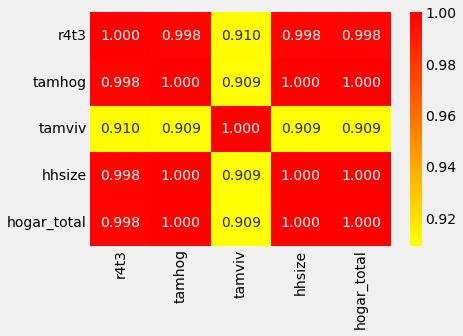

In [69]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

집의 크기와 관련된 몇 가지 변수가 있습니다.

r4t3, 가구원 총계입니다.
Tamhog, 가구의 크기입니다.
tamviv, 가구원 수
hhsize, 가구 크기입니다.
hogar_total, 가구 내 총 개인 수입니다.

이 변수들은 모두 서로 높은 상관관계를 가지고 있습니다. 사실 hhsize는 tamhog 및 hogar_total과 완벽한 상관관계를 가지고 있습니다. 정보가 중복되기 때문에 우리는 이 두 변수를 제거할 것입니다. 또한 r4t3은 hhsize와 거의 완벽한 상관관계가 있기 때문에 제거할 수 있습니다.

tamviv는 가정에 살지 않는 가족 구성원이 있을 수 있기 때문에 반드시 hhsize와 같은 것은 아니다. 이 차이를 산점도에서 시각화해 보겠습니다.

In [73]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HOME\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


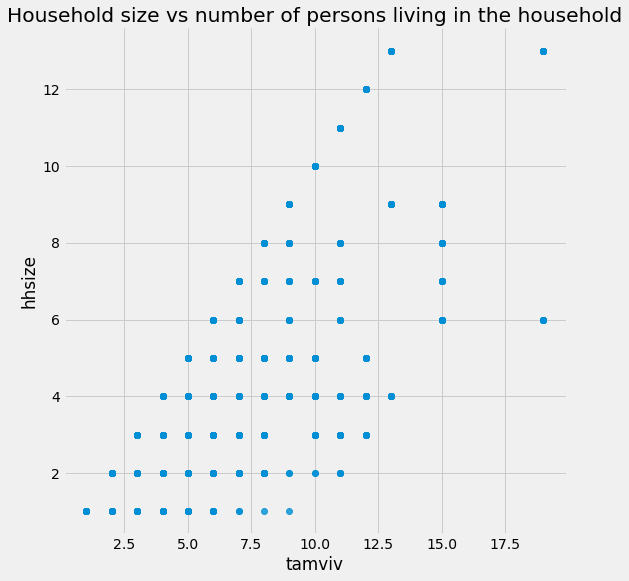

In [74]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

많은 경우에서 볼 때, 가족보다 더 많은 사람들이 살고 있습니다. 이것은 새로운 특징, 즉 이 두 측정값의 차이에 대한 좋은 아이디어를 제공합니다!

Let's make this new feature.




C:\Users\HOME\AppData\Local\Temp/ipykernel_11036/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


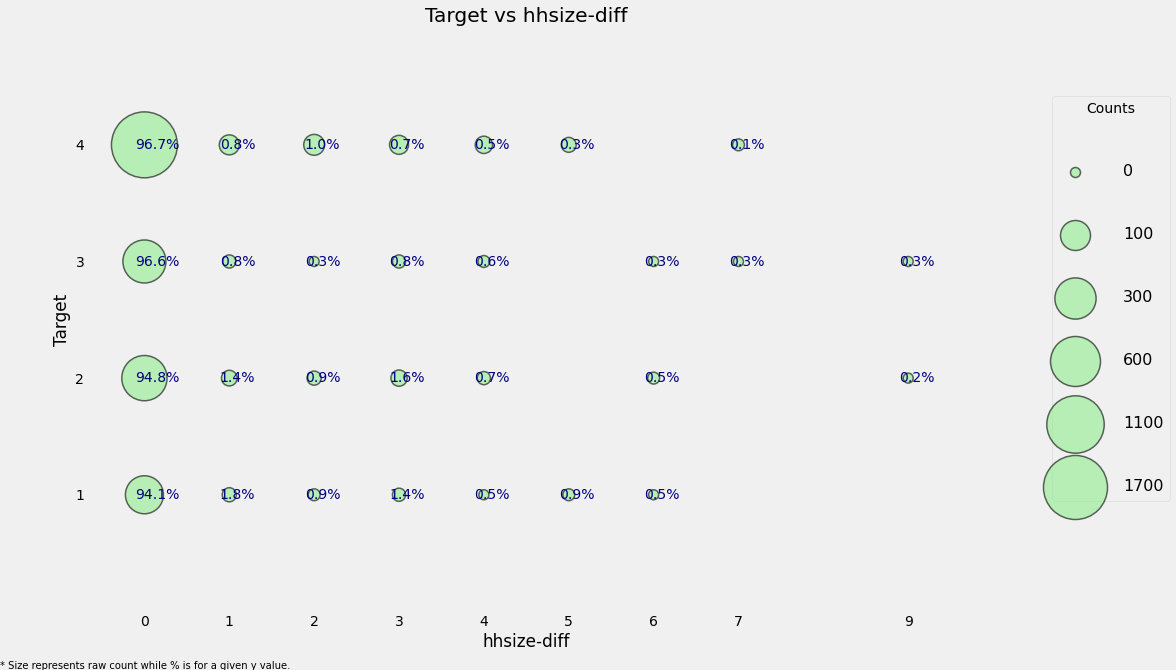

In [76]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

대부분의 가구는 차이가 없지만, 가구원보다 더 많은 사람이 살고 있는 가구가 몇 명 있습니다.

다른 중복 변수로 넘어가겠습니다. 먼저 우리는 쿠플을 볼 수 있습니다.

In [77]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수들은 가정의 전기가 어디에서 오는지 나타냅니다. 네 가지 옵션이 있는데, 이 두 가지 옵션 중 하나가 없는 가정은 전기가 들어오지 않거나(노엘렉) 개인 공장(플랜프리)에서 얻습니다.

순서형 변수를 작성하는 중입니다.
순서형 변수를 만들어서 이 네 변수를 하나로 압축해 보겠습니다. 데이터 구분에 따라 직접 매핑을 선택할 것입니다.

0: 전기가 들어오지 않습니다.
1: 협동조합에서 전기를 공급받습니다.
2: CNFL, ICA, ESPH/JASEC에서 전기를 공급받습니다.
3: 개인 발전소에서 전기를 공급받습니다.

정렬된 변수는 고유의 순서를 가지고 있으며, 이를 위해 도메인 지식을 기반으로 우리 자신의 순서를 선택합니다. 우리가 이 새로운 오더 변수를 만든 후에 나머지 4개를 삭제할 수 있습니다. 여기에 변수가 없는 가구가 여러 개 있으므로 nan(귀속 시 채워질 것)을 사용하고 이 변수에 대한 측도가 없음을 나타내는 부울 열을 추가합니다.


In [78]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

C:\Users\HOME\AppData\Local\Temp/ipykernel_11036/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


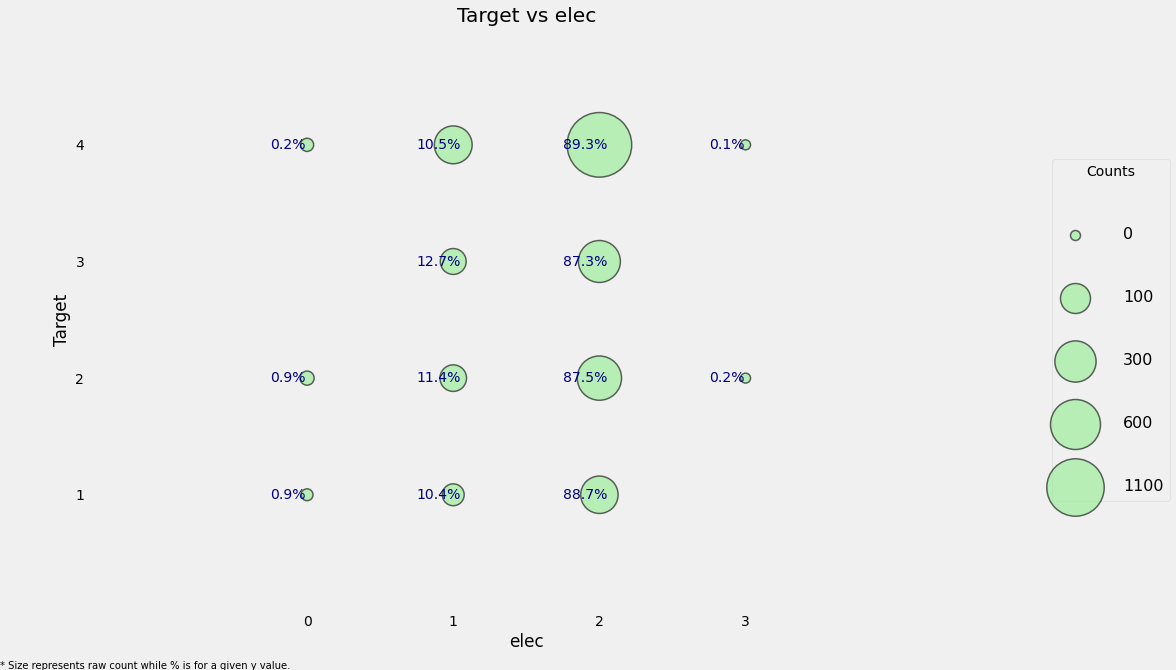

In [79]:
plot_categoricals('elec', 'Target', heads)

타깃의 모든 값에 대해 가장 일반적인 전력 공급원은 나열된 공급자 중 한 곳임을 알 수 있습니다.
